# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de El Hierro

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    color_isla = 'purple'
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True, 
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_ElHierro = datos[datos['isla'] == 'EL HIERRO']

datos_ElHierro = datos_ElHierro.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'El Hierro'         # Isla a la que se está realziando el estudio
fechas = datos_ElHierro.tail(dias_prediccion).index # Fechas de los días a predecir

variables_covid = [objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = [objetivo, 'tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = [objetivo,'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables


In [5]:
# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_ElHierro_uni = datos_ElHierro[objetivo]
datos_ElHierro_uni_arr = np.array(datos_ElHierro_uni).reshape(-1, 1)

datos_ElHierro_mult_covid = datos_ElHierro[variables_covid]
datos_ElHierro_mult_atm = datos_ElHierro[variables_atm]
datos_ElHierro_mult_total = datos_ElHierro[variables]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_ElHierro_uni_scaled = scaler.fit_transform(datos_ElHierro_uni_arr)

In [7]:
n_train = len(datos_ElHierro_uni_scaled) - dias_prediccion


train = datos_ElHierro_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_ElHierro_uni_scaled[n_train - dias_prediccion:len(datos_ElHierro_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 6s 113ms/step - loss: 0.0496 - val_loss: 0.0329
Epoch 2/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0454 - val_loss: 0.0296
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0439 - val_loss: 0.0294
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0424 - val_loss: 0.0272
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0407 - val_loss: 0.0266
Epoch 6/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0395 - val_loss: 0.0258
Epoch 7/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0376 - val_loss: 0.0241
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0360 - val_loss: 0.0233
Epoch 9/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0344 - val_loss: 0.0230
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0322 - val_loss: 0.0218
Epoch 11/50
7/7 [===========

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 1s 617ms/step


In [11]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 8, número de casos predichos 11.266723
2022-03-20: número de casos reales 2, número de casos predichos 9.967472
2022-03-21: número de casos reales 11, número de casos predichos 8.912724
2022-03-22: número de casos reales 12, número de casos predichos 6.849926
2022-03-23: número de casos reales 17, número de casos predichos 7.4869027
2022-03-24: número de casos reales 4, número de casos predichos 7.7014637
2022-03-25: número de casos reales 10, número de casos predichos 7.2091002
2022-03-26: número de casos reales 1, número de casos predichos 6.635996
2022-03-27: número de casos reales 3, número de casos predichos 6.569021
2022-03-28: número de casos reales 4, número de casos predichos 6.8340535


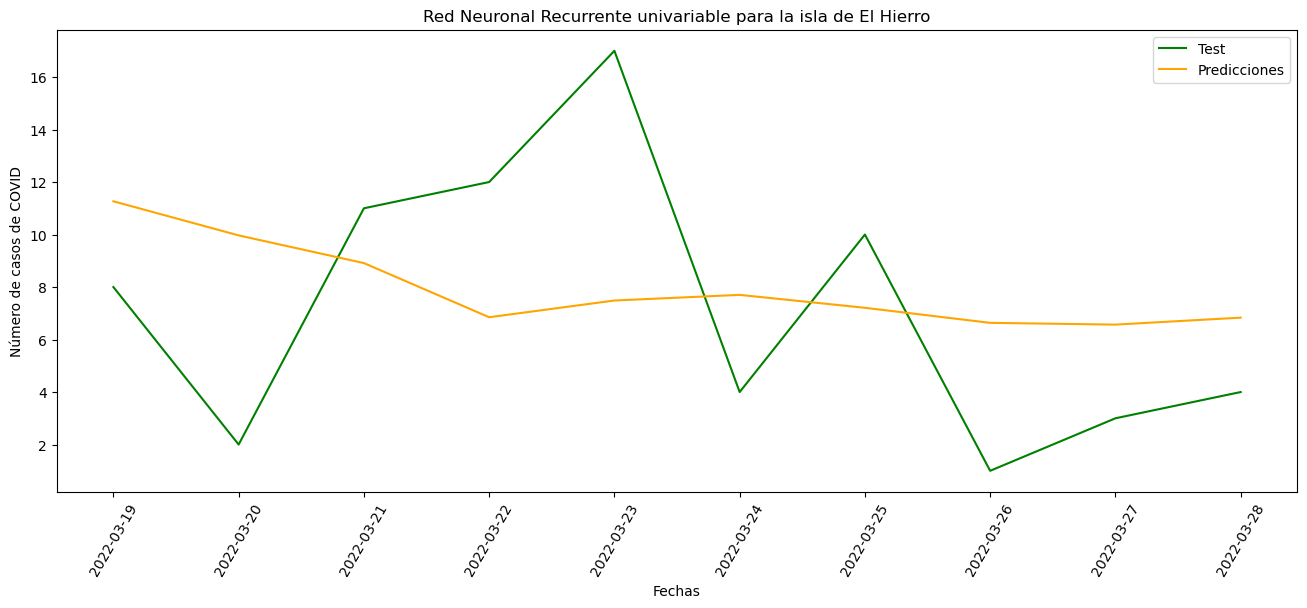

In [12]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

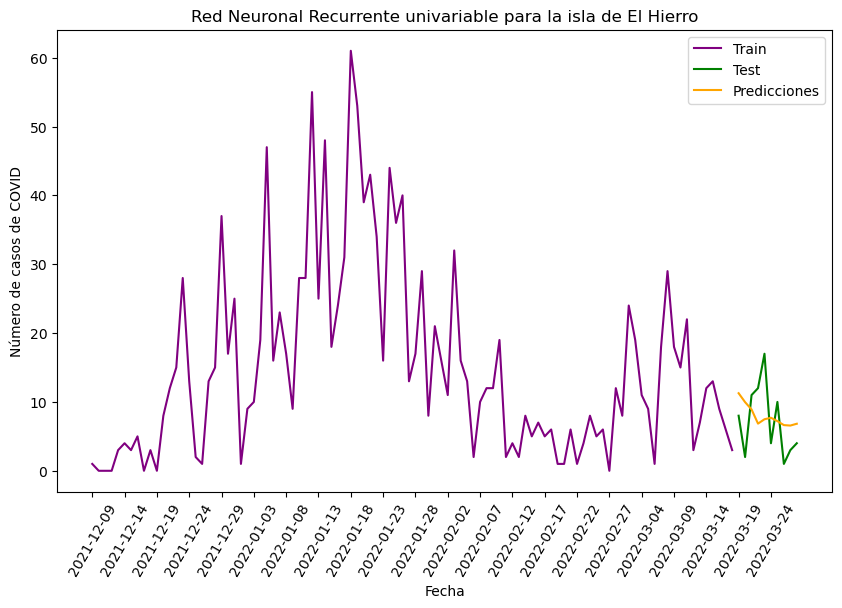

In [13]:
datos_train = datos_ElHierro_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [14]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 26.955526978043576
Error absoluto medio (MAE) del modelo: 4.651607656478882
Raíz del error cuadrático medio (RMSE) del modelo: 5.1918712405108405


# Red Neuronal Recurrente multivariable con variables de pandemia

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_ElHierro_mult_covid_scaled = scaler.fit_transform(datos_ElHierro_mult_covid)


# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_ElHierro_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_ElHierro_mult_covid[objetivo]).reshape(-1, 1))

In [16]:
n_train = len(datos_ElHierro_mult_covid_scaled) - dias_prediccion


train = datos_ElHierro_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_ElHierro_mult_covid_scaled[n_train - dias_prediccion:len(datos_ElHierro_mult_covid_scaled), :]

In [17]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [18]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 6s 118ms/step - loss: 0.0427 - val_loss: 0.0264
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0390 - val_loss: 0.0248
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0372 - val_loss: 0.0230
Epoch 4/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0348 - val_loss: 0.0221
Epoch 5/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0324 - val_loss: 0.0223
Epoch 6/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0294 - val_loss: 0.0207
Epoch 7/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0271 - val_loss: 0.0192
Epoch 8/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0253 - val_loss: 0.0193
Epoch 9/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0235 - val_loss: 0.0187
Epoch 10/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0215 - val_loss: 0.0182
Epoch 11/50
7/7 [===========

In [19]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 1s 1s/step


In [20]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 8, número de casos predichos 10.689645
2022-03-20: número de casos reales 2, número de casos predichos 9.024785
2022-03-21: número de casos reales 11, número de casos predichos 7.5093536
2022-03-22: número de casos reales 12, número de casos predichos 5.5436215
2022-03-23: número de casos reales 17, número de casos predichos 6.304252
2022-03-24: número de casos reales 4, número de casos predichos 6.5183387
2022-03-25: número de casos reales 10, número de casos predichos 5.2090917
2022-03-26: número de casos reales 1, número de casos predichos 4.3911266
2022-03-27: número de casos reales 3, número de casos predichos 4.3097377
2022-03-28: número de casos reales 4, número de casos predichos 4.551558


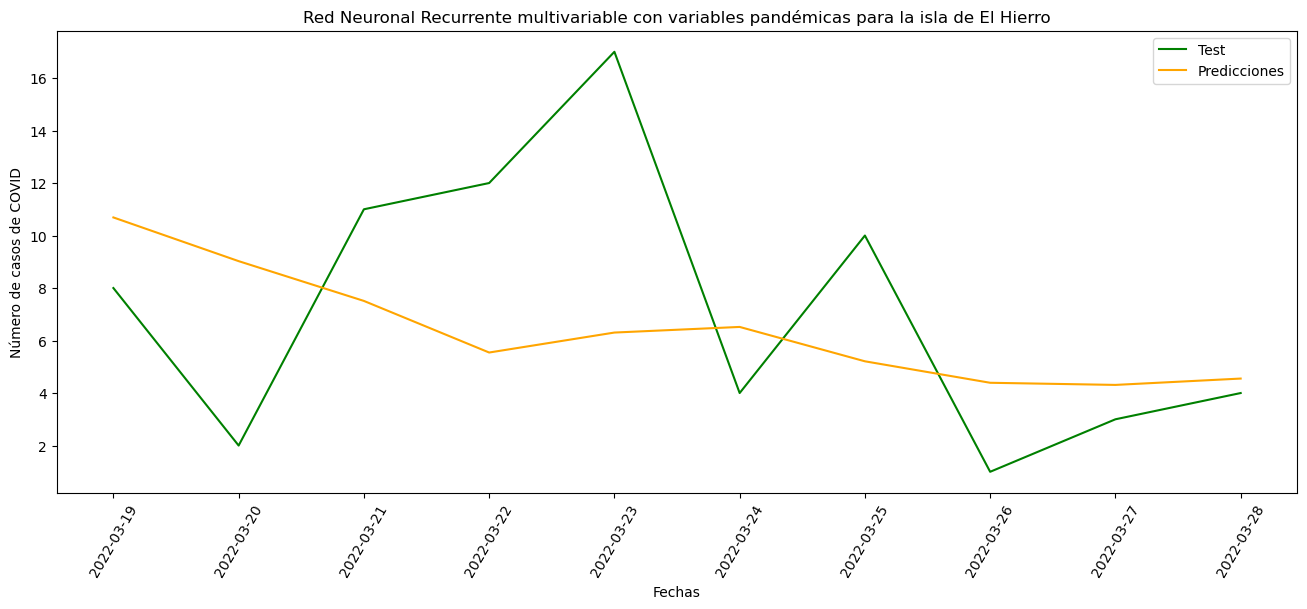

In [21]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

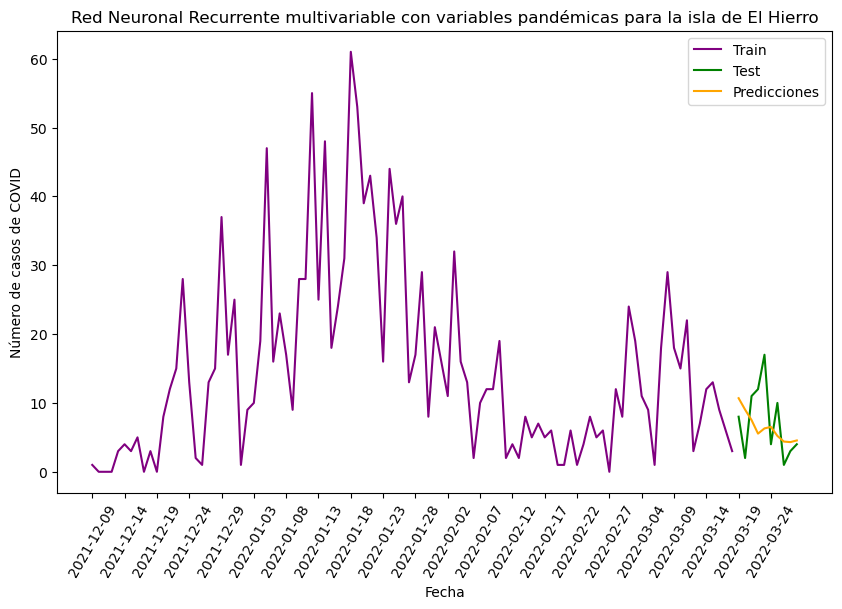

In [22]:
datos_train = datos_ElHierro_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [23]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 26.766445235268794
Error absoluto medio (MAE) del modelo: 4.291887187957764
Raíz del error cuadrático medio (RMSE) del modelo: 5.173629793024313


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_ElHierro_mult_atm_scaled = scaler.fit_transform(datos_ElHierro_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_ElHierro_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_ElHierro_mult_atm[objetivo]).reshape(-1, 1))

In [25]:
n_train = len(datos_ElHierro_mult_atm_scaled) - dias_prediccion


train = datos_ElHierro_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_ElHierro_mult_atm_scaled[n_train - dias_prediccion:len(datos_ElHierro_mult_atm_scaled), :]

In [26]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [27]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 5s 117ms/step - loss: 0.0453 - val_loss: 0.0268
Epoch 2/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0413 - val_loss: 0.0262
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0373 - val_loss: 0.0241
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0356 - val_loss: 0.0235
Epoch 5/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0344 - val_loss: 0.0224
Epoch 6/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0316 - val_loss: 0.0258
Epoch 7/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0298 - val_loss: 0.0214
Epoch 8/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0286 - val_loss: 0.0263
Epoch 9/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0282 - val_loss: 0.0212
Epoch 10/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0263 - val_loss: 0.0239
Epoch 11/50
7/7 [===========

In [28]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 1s 1s/step


In [29]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 8, número de casos predichos 15.205775
2022-03-20: número de casos reales 2, número de casos predichos 13.600031
2022-03-21: número de casos reales 11, número de casos predichos 12.245863
2022-03-22: número de casos reales 12, número de casos predichos 10.668472
2022-03-23: número de casos reales 17, número de casos predichos 11.156816
2022-03-24: número de casos reales 4, número de casos predichos 11.127398
2022-03-25: número de casos reales 10, número de casos predichos 10.954926
2022-03-26: número de casos reales 1, número de casos predichos 10.673819
2022-03-27: número de casos reales 3, número de casos predichos 10.700267
2022-03-28: número de casos reales 4, número de casos predichos 10.846298


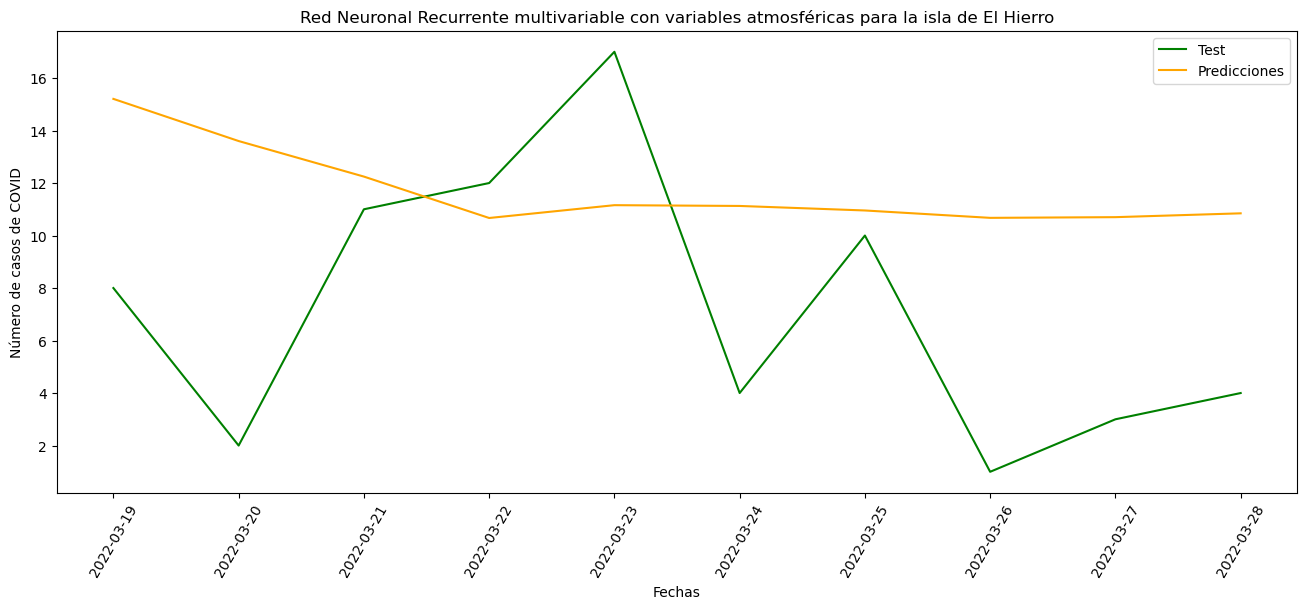

In [30]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

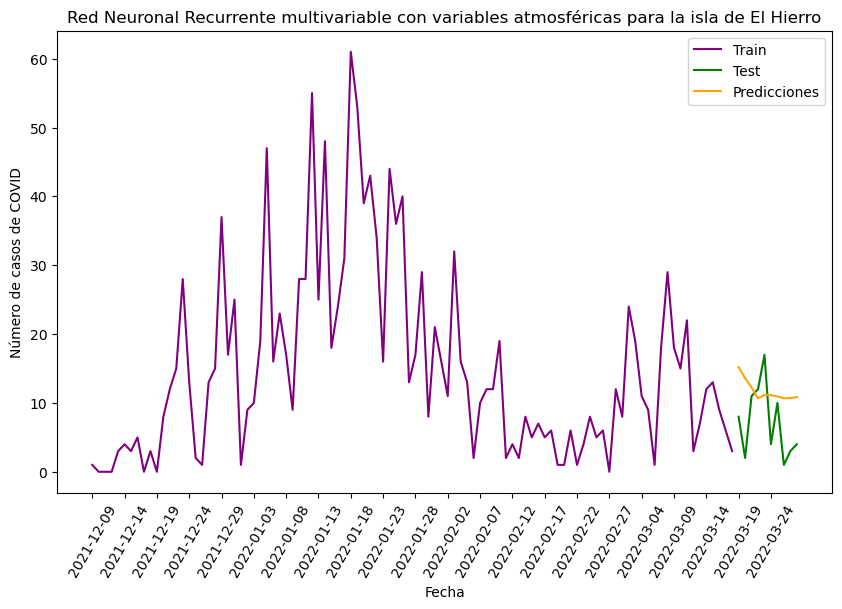

In [31]:
datos_train = datos_ElHierro_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [32]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 47.54122124708984
Error absoluto medio (MAE) del modelo: 5.9529088020324705
Raíz del error cuadrático medio (RMSE) del modelo: 6.895014231101328


# Red Neuronal Recurrente multivariable con todas las variables

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_ElHierro_mult_total_scaled = scaler.fit_transform(datos_ElHierro_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_ElHierro_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_ElHierro_mult_total[objetivo]).reshape(-1, 1))

In [34]:
n_train = len(datos_ElHierro_mult_total_scaled) - dias_prediccion


train = datos_ElHierro_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_ElHierro_mult_total_scaled[n_train - dias_prediccion:len(datos_ElHierro_mult_total_scaled), :]

In [35]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [36]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 6s 118ms/step - loss: 0.0461 - val_loss: 0.0301
Epoch 2/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0425 - val_loss: 0.0267
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0390 - val_loss: 0.0251
Epoch 4/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0347 - val_loss: 0.0244
Epoch 5/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0336 - val_loss: 0.0237
Epoch 6/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0310 - val_loss: 0.0239
Epoch 7/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0283 - val_loss: 0.0224
Epoch 8/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0273 - val_loss: 0.0281
Epoch 9/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0270 - val_loss: 0.0238
Epoch 10/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0247 - val_loss: 0.0207
Epoch 11/50
7/7 [===========

In [37]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 461ms/step


In [38]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 8, número de casos predichos 15.956445
2022-03-20: número de casos reales 2, número de casos predichos 14.170133
2022-03-21: número de casos reales 11, número de casos predichos 12.443193
2022-03-22: número de casos reales 12, número de casos predichos 9.8322315
2022-03-23: número de casos reales 17, número de casos predichos 10.849849
2022-03-24: número de casos reales 4, número de casos predichos 11.055266
2022-03-25: número de casos reales 10, número de casos predichos 9.333064
2022-03-26: número de casos reales 1, número de casos predichos 8.3070545
2022-03-27: número de casos reales 3, número de casos predichos 8.002913
2022-03-28: número de casos reales 4, número de casos predichos 8.149094


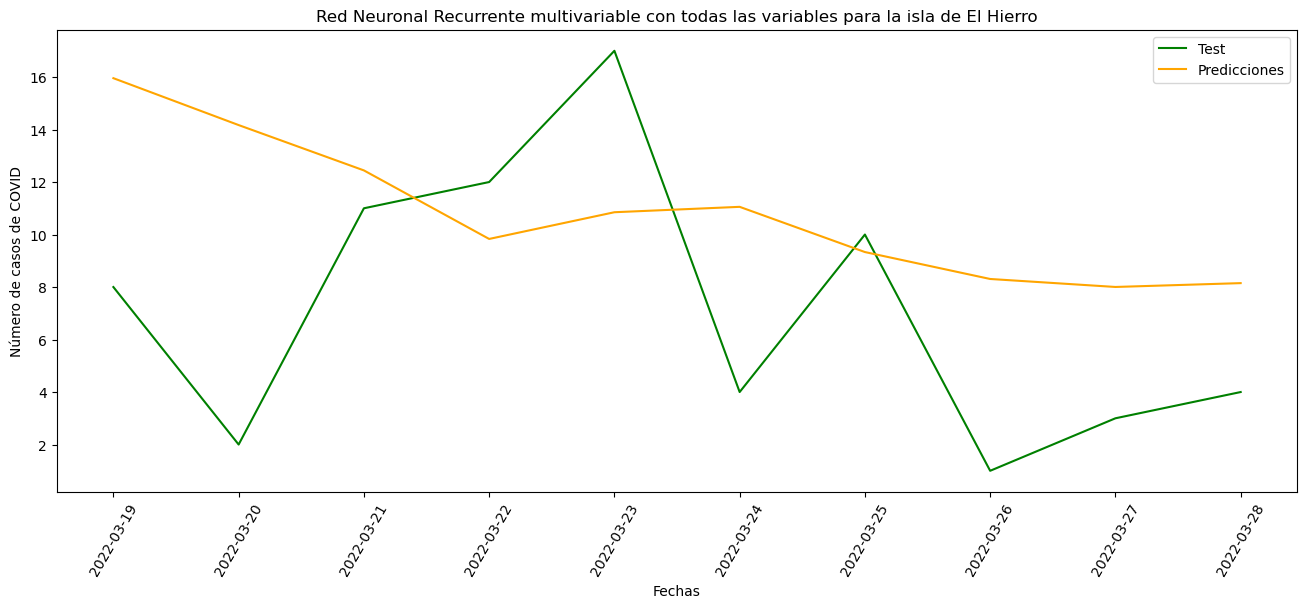

In [39]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

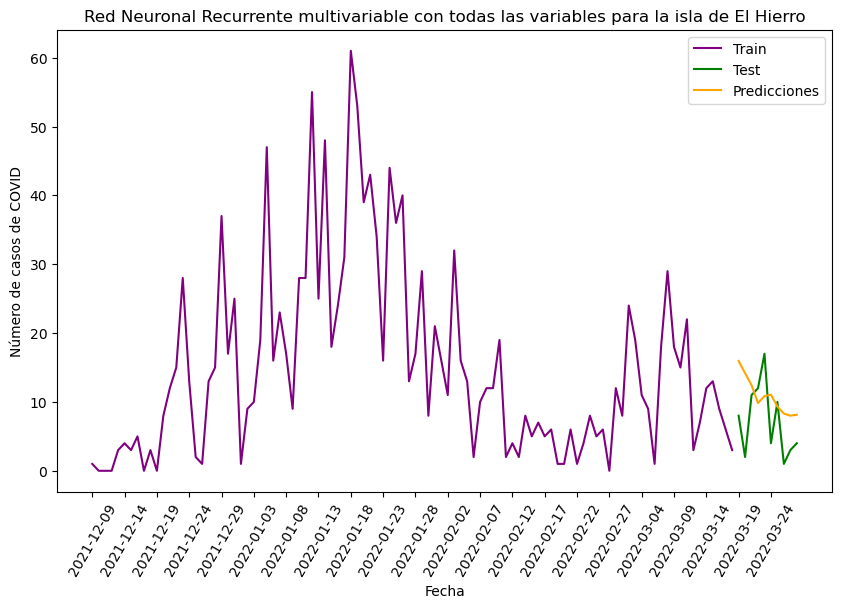

In [40]:
datos_train = datos_ElHierro_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [41]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 40.1882283353154
Error absoluto medio (MAE) del modelo: 5.406895446777344
Raíz del error cuadrático medio (RMSE) del modelo: 6.339418611774695
